# ===========================================================
# ML1010 - Final Project: Mid-Term Proposal
# Team NLP

## Amit Asghar
## Benjamin Kan
## Lingling Zhang
## Sophie Lee

# Sentiment Analysis for Yelp Customer Reviews on Chinese Restaurants
# ===========================================================

# Introduction

We work in a multi-national marketing firm with clients around the world servicing a wide range of industries such as chained restaurants, financial services and oil and gas firms. In order to expand our product offering, we have established a data science team to augment our existing marketing consulting services by providing clients insights and anticipating consumer trends to make their marketing campaigns become more effective. 

We have a chained Chinese restaurant client who own 50 restaurants across North America. Recently, the restaurant owner is looking into modernizing their brand to attract more Millennial customers. Our task is to create an effective marketing campaign for them. To achieve this goal, we decided to leverage our data science capabilities to conduct Sentiment Analysis on the customer reviews on Yelp for Chinese restaurants. The result of the analysis will form an important input to our marketing campaign. 
 

# Data Collection

## Data Source
The original dataset is from Yelp (https://www.yelp.com/dataset). It consists of the following sub-datasets in json format:

* business.json: Contains business data including location data, attributes, and categories.
* review.json: Contains full review text data including the user_id that wrote the review and the business_id the review is written for.
* user.json: User data including the user's friend mapping and all the metadata associated with the user.
* checkin.json: Checkins on a business.
* tip.json: Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.

In this project, we will mainly use the information in the business and review files.

The original review dataset has more than 6 million reviews. In order to select the reviews pertained to Chinese restaurants, we performed the following filtering routine:

* Using the business dataset, obtain a list of business IDs which are Chinese restaurants by searching for key word "Chinese" in the business categories column.
* Under the review dataset, select the relevant reviews based on the list of business IDs

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import collections
import re, string
import sys
import time
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [2]:
# load business JSON file
business_df = pd.read_json("yelp_academic_dataset_business.json", lines=True)
print(business_df.head())
print(business_df.shape)

chinese_restaurants = business_df[business_df['categories'].str.contains('Chinese') == True]

print(chinese_restaurants.head())
print(chinese_restaurants.shape)

#chinese_restaurants.to_csv('chinese_business.csv')

               address                                         attributes  \
0    1314 44 Avenue NE  {'BikeParking': 'False', 'BusinessAcceptsCredi...   
1                       {'Alcohol': 'none', 'BikeParking': 'False', 'B...   
2  1335 rue Beaubien E  {'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...   
3      211 W Monroe St                                               None   
4  2005 Alyth Place SE             {'BusinessAcceptsCreditCards': 'True'}   

              business_id                                         categories  \
0  Apn5Q_b6Nz61Tq4XzPdf9A  Tours, Breweries, Pizza, Restaurants, Food, Ho...   
1  AjEbIBw6ZFfln7ePHha9PA  Chicken Wings, Burgers, Caterers, Street Vendo...   
2  O8S5hYJ1SMc8fA4QBtVujA  Breakfast & Brunch, Restaurants, French, Sandw...   
3  bFzdJJ3wp3PZssNEsyU23g                      Insurance, Financial Services   
4  8USyCYqpScwiNEb58Bt6CA  Home & Garden, Nurseries & Gardening, Shopping...   

        city                                            

The code above shows that there are 4,468 Chinese restaurants. As for selecting the relevant reviews based on the business IDs for the 4,468 Chinese restaurants, because it is very computationally expensive, we extracted these reviews separately. Below is the relevant reviews in csv format.

In [3]:
# load Chinese restaurant review file
chinese_reviews_df = pd.read_csv("yelp_chinese_review.csv")
print(chinese_reviews_df.head())
print(chinese_reviews_df.shape)


   funny                 user_id               review_id  \
0      0  0pf5VuzE4_1pwj5NJHG5TQ  oz66Z8p9Etq0WbcZVCmm7w   
1      1  0pf5VuzE4_1pwj5NJHG5TQ  oyhOp2Eu7A9rsnmoV0VFgA   
2      0  0pf5VuzE4_1pwj5NJHG5TQ  8k2WpYJFfsPL3kupmvGjWA   
3      0  0pf5VuzE4_1pwj5NJHG5TQ  JvCsQXCkTkybpkJd8oSimw   
4      0  Yy_iGXxLpL6tYDQoE-6XVg  mqhCY5oLA1LXP6gZ3JQDTQ   

                                                text             business_id  \
0  Friendliest staff, no matter how swamped they ...  OX0T9dWI8b7meu-ljTo22A   
1  Been coming here for years, always delicious f...  SVMR0kRmdd-bbSNTTECJBA   
2  Best place for dim sum in the valley.  Prefer ...  szhJLmdLDVFTevm8fu0T4A   
3  Love the house chicken and chicken fried rice....  A2pHOVp0zh7grb1bbZxoBQ   
4  The spicy wonton was my favorite. We ordered a...  JPfi__QJAaRzmfh5aOyFEw   

   stars        date  useful  cool  
0      5  2016-05-01       0     0  
1      5  2016-03-06       0     0  
2      5  2016-05-01       0     0  
3      4  

As we can see, the review dataset has been narrowed down from 6 million to 227,132 reviews.

## Prepare Review Dataset for Data Exploration

In order to perform effective data exploration, we are merging the business dataset with the review dataset.

In [4]:
chinese_reviews_df_full = pd.merge(chinese_reviews_df,right=business_df, how="inner",on='business_id')
chinese_reviews_df_full.rename(columns = {'stars_x': 'stars',
                                   'stars_y': 'stars_business',},inplace=True)
chinese_reviews_df_full.to_csv('yelp_chinese_review_full.csv')
print(chinese_reviews_df_full.head())
print(chinese_reviews_df_full.shape)

   funny                 user_id               review_id  \
0      0  0pf5VuzE4_1pwj5NJHG5TQ  oz66Z8p9Etq0WbcZVCmm7w   
1      0  ZuCXUnvBXN9wj2S8ZD40qw  0Z4uMWbCUKKtzDFeOoQt3Q   
2      0  NH7hMsA2Mogeboht1-XEVQ  AKTWTO0aUe8GMnax51aSjA   
3      0  o5hp_ni5e0SrCTczzEajuA  qrNDl6NDPS_4u8T5VJMx9g   
4      0  4SJbA5cVsHHVBt3bpGHTzg  HFFV71RDN0odsR1a7Bc9oA   

                                                text             business_id  \
0  Friendliest staff, no matter how swamped they ...  OX0T9dWI8b7meu-ljTo22A   
1  getting some food I wish it was a lot bigger t...  OX0T9dWI8b7meu-ljTo22A   
2  The place is a pit and it always has been a pi...  OX0T9dWI8b7meu-ljTo22A   
3  I have been coming to long wongs for 10 years!...  OX0T9dWI8b7meu-ljTo22A   
4  For the most part it's a unique and different ...  OX0T9dWI8b7meu-ljTo22A   

   stars        date  useful  cool           address  ...   \
0      5  2016-05-01       0     0  2812 E Thomas Rd  ...    
1      4  2013-12-10       0     0

# Review Ratings Normalization and Create Sentiment Label

As in any other typical Sentiment Analysis problems, we encounter an issue: certain raters are more lenient or strict than other raters. For example, a strict rater could just give only a neutral rating (3 stars) even he or she is completely satisfied with the restaurant. However, a more lenient rater would give a positive rating (5 stars) for the same dining experience. In order to bring the rating standard to be more consistent, we would need to normalize the rating grouped by users.

In [5]:
chinese_reviews_df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227132 entries, 0 to 227131
Data columns (total 23 columns):
funny             227132 non-null int64
user_id           227132 non-null object
review_id         227132 non-null object
text              227132 non-null object
business_id       227132 non-null object
stars             227132 non-null int64
date              227132 non-null object
useful            227132 non-null int64
cool              227132 non-null int64
address           227132 non-null object
attributes        226711 non-null object
categories        227132 non-null object
city              227132 non-null object
hours             208215 non-null object
is_open           227132 non-null int64
latitude          227132 non-null float64
longitude         227132 non-null float64
name              227132 non-null object
neighborhood      227132 non-null object
postal_code       227132 non-null object
review_count      227132 non-null int64
stars_business    227132 non-nul

In [6]:
# create a new df 'group_user'
group_user = chinese_reviews_df_full.groupby(['user_id'], as_index = False, sort = False)
type(group_user)

pandas.core.groupby.groupby.DataFrameGroupBy

In [7]:
# compute the mean star rating per user
stars_mean = pd.DataFrame(group_user["stars"].mean())
stars_mean.rename(columns = {'stars': 'stars_mean'},inplace=True)
print(stars_mean.head())
#stars_mean = stars_mean.rename(columns = {'stars': 'stars_mean'},inplace=True)
#print(stars_mean)

                  user_id  stars_mean
0  0pf5VuzE4_1pwj5NJHG5TQ        4.75
1  ZuCXUnvBXN9wj2S8ZD40qw        4.00
2  NH7hMsA2Mogeboht1-XEVQ        1.00
3  o5hp_ni5e0SrCTczzEajuA        5.00
4  4SJbA5cVsHHVBt3bpGHTzg        4.00


In [8]:
# merge two df: merge reviews with stars_mean
chinese_reviews_df_norm = pd.merge(chinese_reviews_df_full, stars_mean, on = 'user_id', how = 'left', sort = 'False')
print(chinese_reviews_df_norm.head())

   funny                 user_id               review_id  \
0      1  ---1lKK3aKOuomHnwAkAow  iX0tGIeZiVwyQYFaGXXAIA   
1      0  ---cu1hq55BP9DWVXXKHZg  O0frjb1NA2AD5VnHNWVpcg   
2      0  --2HUmLkcNHZp0xw6AMBPg  wK3roBOGrakzjoX_o5nmBw   
3      0  --2HUmLkcNHZp0xw6AMBPg  chp1hXWLG4HHiu3RiZFBZQ   
4      0  --3oMd6gjXpAzhjLBrsVCQ  N5ll-GUDd9ITu0fY38fM2Q   

                                                text             business_id  \
0  I wish I had known more about this when I was ...  D1PhUlkQA1ZsVe9Cx4yqOw   
1  Somehow 11111 N 7th Street is "too far for us....  eCJDiRPoSuA0bsb7F1gNUA   
2  Pretty decent for something a little different...  cHdJXLlKNWixBXpDwEGb_A   
3  Great price point to plate ratio.  Amazing sus...  Xfod0UWr_9B-TOM6qxVIwQ   
4  Clean and service is great, and I went at 7:30...  21lt9KBnxcKtQagmImBOpg   

   stars        date  useful  cool                           address  \
0      5  2011-12-11       1     0        3053 W Craig Rd, Ste E-195   
1      1  2014

In [9]:
# in df 'reviews', create a new column 'stars_norm', it = stars - stars_mean
chinese_reviews_df_norm['stars_norm'] = chinese_reviews_df_norm['stars'] - chinese_reviews_df_norm['stars_mean']
# in df 'reviews', create a new column 'sentiment', based on whether stars_norm is >0, == 0 or <0
chinese_reviews_df_norm['sentiment'] = np.where(chinese_reviews_df_norm.stars_norm > 0, 'positive', 
                        np.where(chinese_reviews_df_norm.stars_norm == 0, 'neutral', 'negative'))
print(chinese_reviews_df_norm.head())
chinese_reviews_df_norm.to_csv('chinese_reviews_df_norm.csv')

   funny                 user_id               review_id  \
0      1  ---1lKK3aKOuomHnwAkAow  iX0tGIeZiVwyQYFaGXXAIA   
1      0  ---cu1hq55BP9DWVXXKHZg  O0frjb1NA2AD5VnHNWVpcg   
2      0  --2HUmLkcNHZp0xw6AMBPg  wK3roBOGrakzjoX_o5nmBw   
3      0  --2HUmLkcNHZp0xw6AMBPg  chp1hXWLG4HHiu3RiZFBZQ   
4      0  --3oMd6gjXpAzhjLBrsVCQ  N5ll-GUDd9ITu0fY38fM2Q   

                                                text             business_id  \
0  I wish I had known more about this when I was ...  D1PhUlkQA1ZsVe9Cx4yqOw   
1  Somehow 11111 N 7th Street is "too far for us....  eCJDiRPoSuA0bsb7F1gNUA   
2  Pretty decent for something a little different...  cHdJXLlKNWixBXpDwEGb_A   
3  Great price point to plate ratio.  Amazing sus...  Xfod0UWr_9B-TOM6qxVIwQ   
4  Clean and service is great, and I went at 7:30...  21lt9KBnxcKtQagmImBOpg   

   stars        date  useful  cool                           address  \
0      5  2011-12-11       1     0        3053 W Craig Rd, Ste E-195   
1      1  2014

# Data Exploration

## Overview of the Reviews

In [10]:
useful_reviews = len(chinese_reviews_df_norm[chinese_reviews_df_norm["useful"]>0])
cool_reviews = len(chinese_reviews_df_norm[chinese_reviews_df_norm["cool"]>0])
funny_reviews = len(chinese_reviews_df_norm[chinese_reviews_df_norm["funny"]>0])
negative_reviws = len(chinese_reviews_df_norm[chinese_reviews_df_norm["sentiment"]=='negative'])
positive_reviews =len(chinese_reviews_df_full[chinese_reviews_df_norm["sentiment"]=='positive'])
neutral_reviews =len(chinese_reviews_df_full[chinese_reviews_df_norm["sentiment"]=='neutral'])
total_reviews = len(chinese_reviews_df_norm)

print("Total reviews: {}".format(total_reviews))
print("Useful reviews: {}".format(useful_reviews))
print("Funny reviews: {}".format(funny_reviews))
print("Cool reviews: {}".format(cool_reviews))
print("Total negative reviews: {}".format(negative_reviws))
print("Total positive reviews: {}".format(positive_reviews))
print("Total neutral reviews: {}".format(neutral_reviews))

Total reviews: 227132
Useful reviews: 104596
Funny reviews: 47953
Cool reviews: 56291
Total negative reviews: 47739
Total positive reviews: 53901
Total neutral reviews: 125492


## Histogram of Sentiment

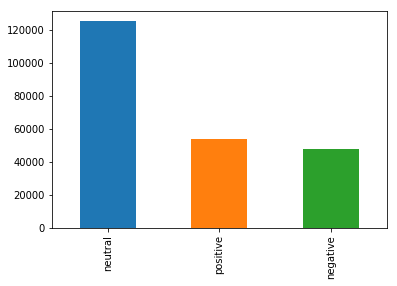

In [11]:
chinese_reviews_df_norm['sentiment'].value_counts().plot(kind='bar')

The histogram above shows that there are more positive reviews.

## Top 20 Positive Reviews Restaurants

In [12]:
top_reviewed = chinese_reviews_df_full[chinese_reviews_df_norm["sentiment"]=='positive']
top_reviews_dict ={}

for business_id in top_reviewed["business_id"].values:
    try :
        top_reviews_dict[business_id] =top_reviews_dict[business_id]+1
    except:
        top_reviews_dict[business_id]=1
        
topbusiness = pd.DataFrame.from_dict(data= top_reviews_dict,orient="index")

topbusiness.reset_index(inplace=True)
topbusiness.columns = ['business_id', 'rated']
del(top_reviews_dict)
del(top_reviewed)
print(topbusiness.head())

              business_id  rated
0  OX0T9dWI8b7meu-ljTo22A     45
1  SVMR0kRmdd-bbSNTTECJBA     43
2  szhJLmdLDVFTevm8fu0T4A     94
3  A2pHOVp0zh7grb1bbZxoBQ     13
4  JPfi__QJAaRzmfh5aOyFEw    181


              business_id  rated         Business name  \
0  OX0T9dWI8b7meu-ljTo22A     45           Long Wong's   
1  SVMR0kRmdd-bbSNTTECJBA     43          Super Dragon   
2  szhJLmdLDVFTevm8fu0T4A     94    Great Wall Cuisine   
3  A2pHOVp0zh7grb1bbZxoBQ     13         Little Peking   
4  JPfi__QJAaRzmfh5aOyFEw    181  Shang Artisan Noodle   

                                          categories  
0  American (Traditional), Pizza, Restaurants, Ar...  
1                Seafood, Chinese, Restaurants, Soup  
2           Chinese, Dim Sum, Restaurants, Cantonese  
3                               Chinese, Restaurants  
4  Asian Fusion, Restaurants, Chinese, Soup, Noodles  


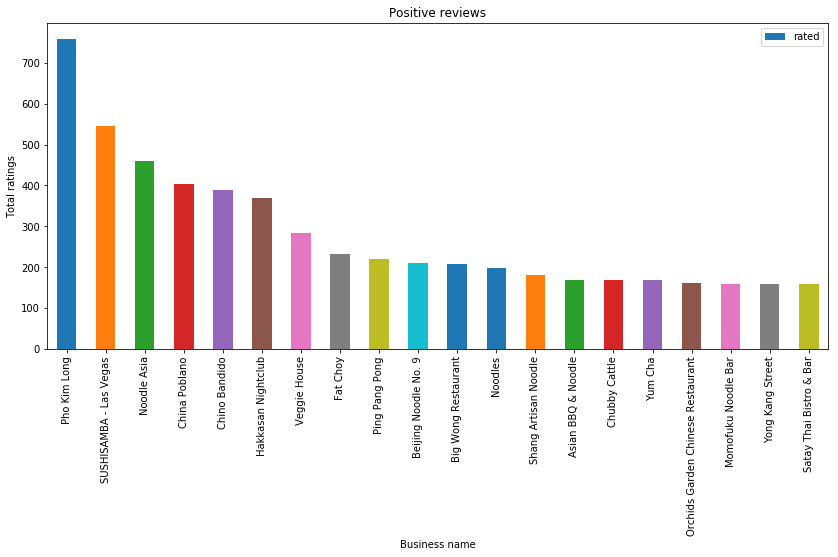

In [13]:
top_count= 20
right=pd.DataFrame(chinese_restaurants[['business_id',"name","categories"]].values,
                    columns=['business_id',"Business name","categories"])

top_business_data = pd.merge(topbusiness,right=right, how="inner",on='business_id')

print(top_business_data.head())
top_business_data.sort_values("rated")[::-1][:top_count].plot(x="Business name",y="rated", 
                                                   kind="bar",figsize=(14,6),
                                                   title='Positive reviews').set_ylabel("Total ratings")

del(topbusiness)
del(right)


## Top 20 Negative Reviews Restaurants

In [14]:
bottom_reviewed = chinese_reviews_df_norm[chinese_reviews_df_norm["sentiment"]=='negative']
bottom_reviews_dict ={}

for business_id in bottom_reviewed["business_id"].values:
    try :
        bottom_reviews_dict[business_id] =bottom_reviews_dict[business_id]+1
    except:
        bottom_reviews_dict[business_id]=1
        
bottombusiness = pd.DataFrame.from_dict(data= bottom_reviews_dict,orient="index")

bottombusiness.reset_index(inplace=True)
bottombusiness.columns = ['business_id', 'rated']
del(bottom_reviews_dict)
del(bottom_reviewed)
print(bottombusiness.head())

              business_id  rated
0  QaxDKkqYTtVYZJcqBNTnvQ     34
1  FcNtrDGaWmkDzlHaq9F1UQ      7
2  zgQHtqX0gqMw1nlBZl2VnQ    263
3  cPzIic1AqH1ApTVVaww5hw     36
4  1ZnVfS-qP19upP_fwOhZsA    161


              business_id  rated                           Business name  \
0  QaxDKkqYTtVYZJcqBNTnvQ     34                   Yummy Yummy Dumplings   
1  FcNtrDGaWmkDzlHaq9F1UQ      7  Szechuan Szechuan Fine Chinese Cuisine   
2  zgQHtqX0gqMw1nlBZl2VnQ    263                     Momofuku Noodle Bar   
3  cPzIic1AqH1ApTVVaww5hw     36                                 Aji Sai   
4  1ZnVfS-qP19upP_fwOhZsA    161                     Big Wong Restaurant   

                                          categories  
0               Chinese, Noodles, Restaurants, Pizza  
1  Ethnic Food, Food, Restaurants, Specialty Food...  
2  Korean, Japanese, Restaurants, Soup, Ramen, Am...  
3         Chinese, Restaurants, Japanese, Sushi Bars  
4  Taiwanese, Noodles, Asian Fusion, Soup, Malays...  


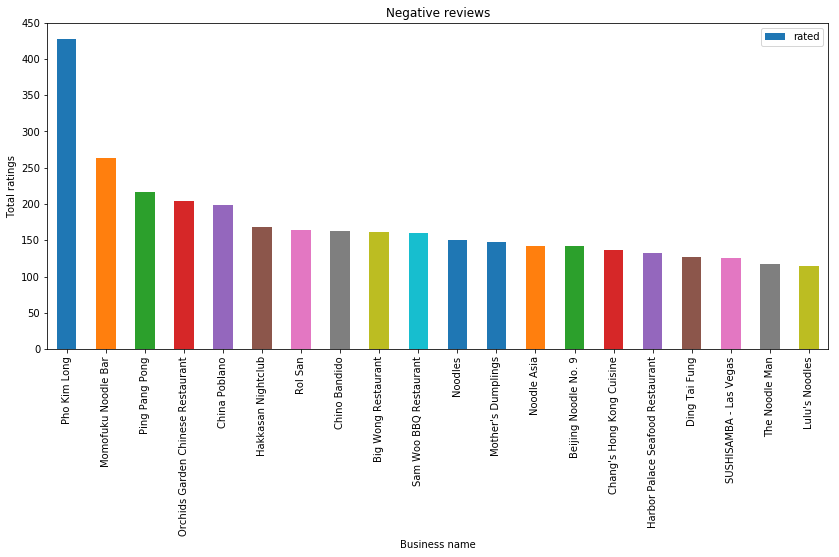

In [15]:
top_count= 20
right=pd.DataFrame(chinese_restaurants[['business_id',"name","categories"]].values,
                    columns=['business_id',"Business name","categories"])

bottom_business_data = pd.merge(bottombusiness,right=right, how="inner",on='business_id')

print(bottom_business_data.head())
bottom_business_data.sort_values("rated")[::-1][:top_count].plot(x="Business name",y="rated", 
                                                   kind="bar",figsize=(14,6),
                                                   title='Negative reviews').set_ylabel("Total ratings")

del(bottombusiness)
del(right)

## Where These Restaurants Are

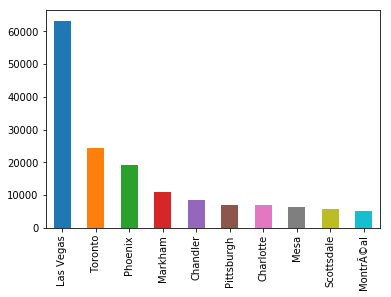

In [26]:
chinese_reviews_df_norm['city'].value_counts().head(10).plot(kind='bar')

As we can see above, most reviewed restaurants come from Las Vegas. This makes sense as the city is a top tourist destination. Toronto comes in second.

In [27]:
# these are helper functions 
# directly copied from https://gist.github.com/benhoyt/dfafeab26d7c02a52ed17b6229f0cb52

def tokenize(s):
    """Convert string to lowercase and split into words (ignoring
    punctuation), returning list of words.
    """
    word_list = re.findall(r'\w+', s.lower())
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    return filtered_words


def count_ngrams(lines, min_length=2, max_length=4):
    """Iterate through given lines iterator (file object or list of
    lines) and return n-gram frequencies. The return value is a dict
    mapping the length of the n-gram to a collections.Counter
    object of n-gram tuple and number of times that n-gram occurred.
    Returned dict includes n-grams of length min_length to max_length.
    """
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

    # Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1

    # Loop through all lines and words and add n-grams to dict
    for line in lines:
        for word in tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()

    # Make sure we get the n-grams at the tail end of the queue
    while len(queue) > min_length:
        queue.popleft()
        add_queue()

    return ngrams

def print_most_frequent(ngrams, num=10):
    """Print num most common n-grams of each length in n-grams dict."""
    for n in sorted(ngrams):
        print('----- {} most common {}-word phrase -----'.format(num, n))
        for gram, count in ngrams[n].most_common(num):
            print('{0}: {1}'.format(' '.join(gram), count))
        print('')

def print_word_cloud(ngrams, num=5):
    """Print word cloud image plot """
    words = []
    for n in sorted(ngrams):
        for gram, count in ngrams[n].most_common(num):
            s = ' '.join(gram)
            words.append(s)
            
    cloud = WordCloud(width=1440, height= 1080,max_words= 200).generate(' '.join(words))
    plt.figure(figsize=(20, 15))
    plt.imshow(cloud)
    plt.axis('off');
    plt.show()
    print('')

# Word Cloud Analysis for the Top Positive and Negative Restaurants

## Word Cloud for Top 3 Most Negative Restaurants

We would like to see the most frequent words used by the reviewers for the top 3 most negative restaurants: Pho King Long, Momofuku Noodle Bar and Ping Pang Pong. For each restaurant, we select the review texts where the sentiment is negative. Here we produce the most common 2-word and 3-word phrase and a word cloud to summarize the most frequent word and phrases

Analysing business:  Pho Kim Long
----- 10 most common 2-word phrase -----
pho kim: 104
kim long: 101
spring rolls: 61
late night: 58
open 24: 55
24 hours: 52
customer service: 46
egg rolls: 41
las vegas: 33
pho place: 30

----- 10 most common 3-word phrase -----
pho kim long: 95
open 24 hours: 34
bun bo hue: 24
open 24 7: 16
place open 24: 8
bun thit nuong: 7
pho dac biet: 7
food came quickly: 7
fried egg rolls: 7
ordered spring rolls: 6



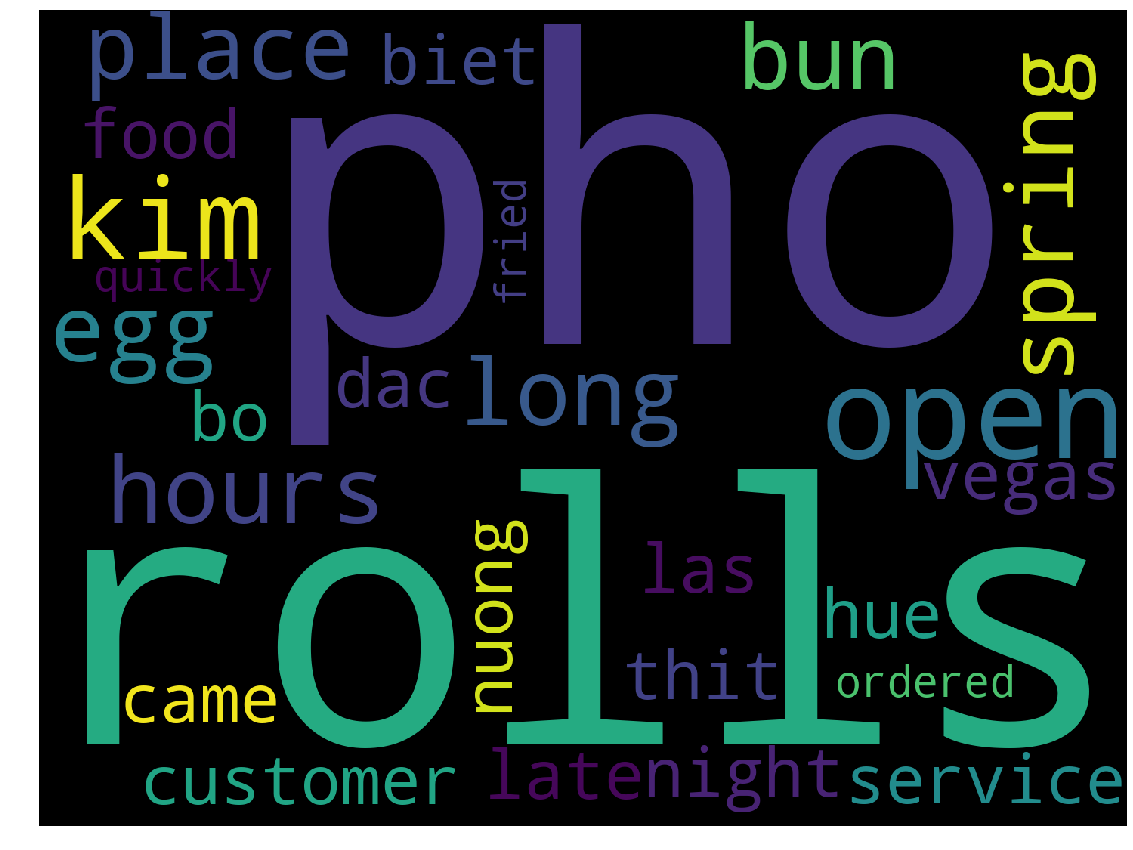


Analysing business:  Momofuku Noodle Bar
----- 10 most common 2-word phrase -----
pork buns: 103
noodle bar: 95
pork belly: 80
momofuku ramen: 59
fried chicken: 43
soft serve: 42
milk bar: 37
momofuku noodle: 33
pork bun: 31
cereal milk: 27

----- 10 most common 3-word phrase -----
momofuku noodle bar: 33
milk soft serve: 14
ordered momofuku ramen: 12
dan dan mein: 12
cereal milk soft: 11
smoked chicken ramen: 10
ramen pork buns: 10
shangri la hotel: 10
ordered pork buns: 9
pork buns 10: 8



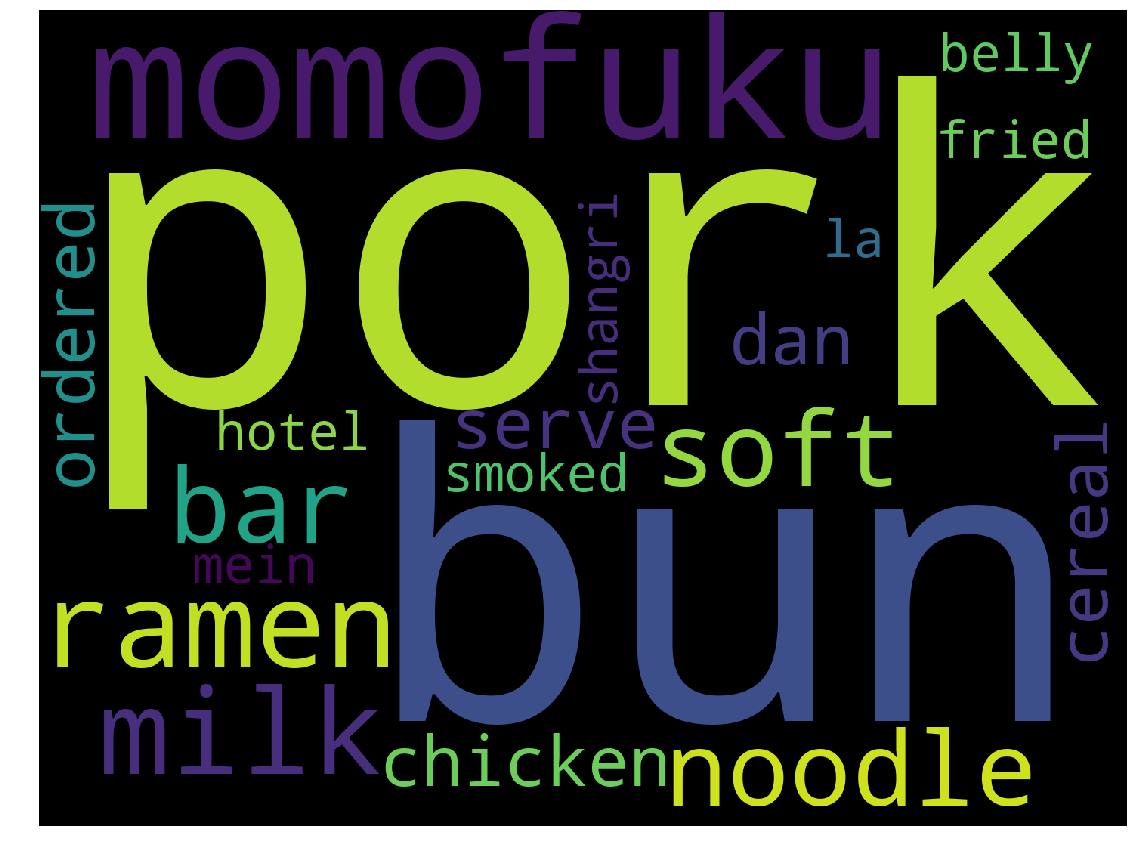


Analysing business:  Ping Pang Pong
----- 10 most common 2-word phrase -----
dim sum: 322
ping pang: 61
pang pong: 59
gold coast: 43
las vegas: 28
sum place: 24
fried rice: 21
chinese food: 20
come back: 19
chinese restaurant: 19

----- 10 most common 3-word phrase -----
ping pang pong: 59
dim sum place: 24
gold coast casino: 18
dim sum places: 18
inside gold coast: 15
best dim sum: 12
located inside gold: 8
place dim sum: 8
dim sum vegas: 8
good dim sum: 8



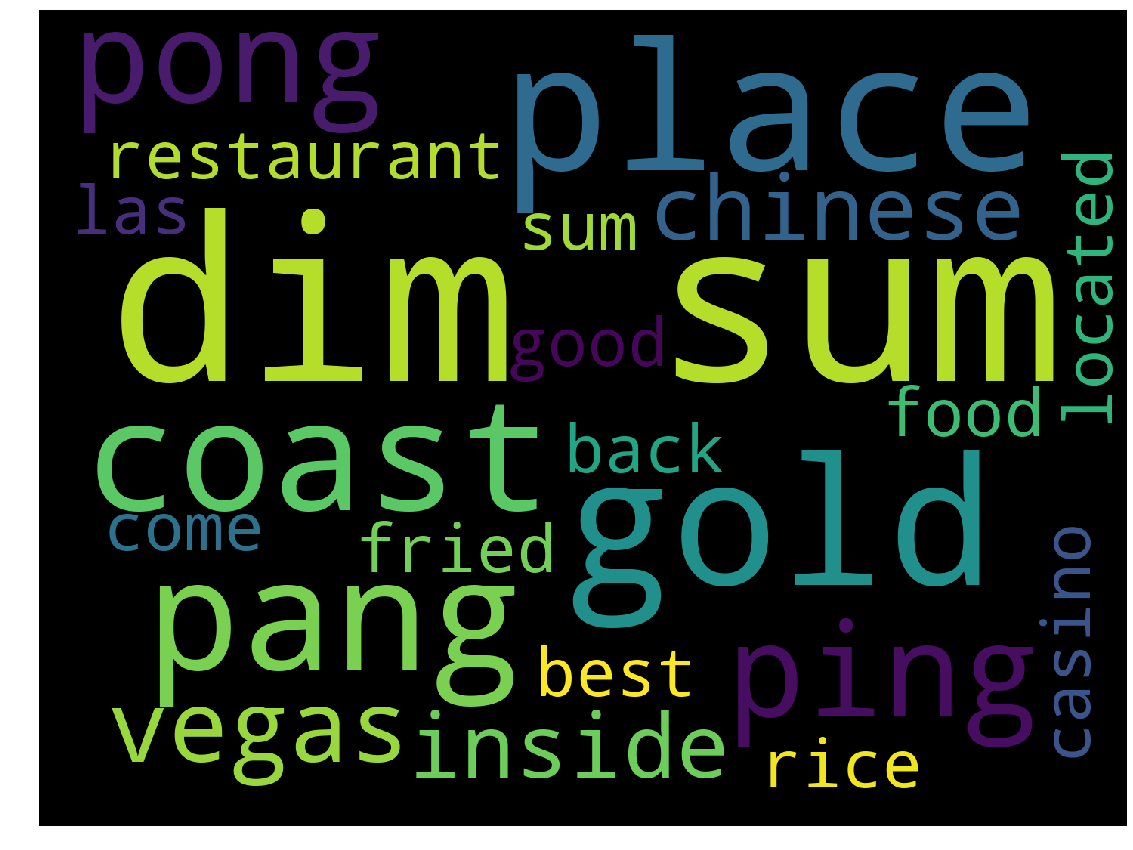

In [44]:
num_business_analysis = 3 # basically this will tell how much computing and diverse our analysis will be
business_ids=bottom_business_data.sort_values("rated")[::-1][:num_business_analysis].business_id.values
business_names = bottom_business_data.sort_values("rated")[::-1][:num_business_analysis]["Business name"].values
# get all the reviews and analyse them
#business_names
for i, business_id in enumerate(business_ids):
    # now extract reviews from reviews data
    print("Analysing business: ",business_names[i])
    reviews = chinese_reviews_df_norm.loc[(chinese_reviews_df_norm['business_id'] == business_id) & (chinese_reviews_df_norm['sentiment'] == 'negative')].text.values
    most_used_text = count_ngrams(reviews,max_length=3)
    print_most_frequent(most_used_text, num=10)
    print_word_cloud(most_used_text, 10)

## Word Cloud for Top 3 Most Positive Restaurants

We would like to see the most frequent words used by the reviewers for the top 3 most postive restaurants: Pho King Long, SUSHISAMBA - Las Vegas and Noodle Asia. For each restaurant, we select the review texts where the sentiment is negative. Here we produce the most common 2-word and 3-word phrase and a word cloud to summarize the most frequent word and phrases

Analysing business:  Pho Kim Long
----- 10 most common 2-word phrase -----
kim long: 127
pho kim: 123
open 24: 76
late night: 70
24 hours: 66
spring rolls: 63
egg rolls: 61
pho place: 44
best pho: 42
24 7: 36

----- 10 most common 3-word phrase -----
pho kim long: 116
open 24 hours: 47
open 24 7: 22
bun bo hue: 16
place open 24: 12
fried egg rolls: 10
bo luc lac: 9
kim long pho: 8
best pho town: 7
late night pho: 7



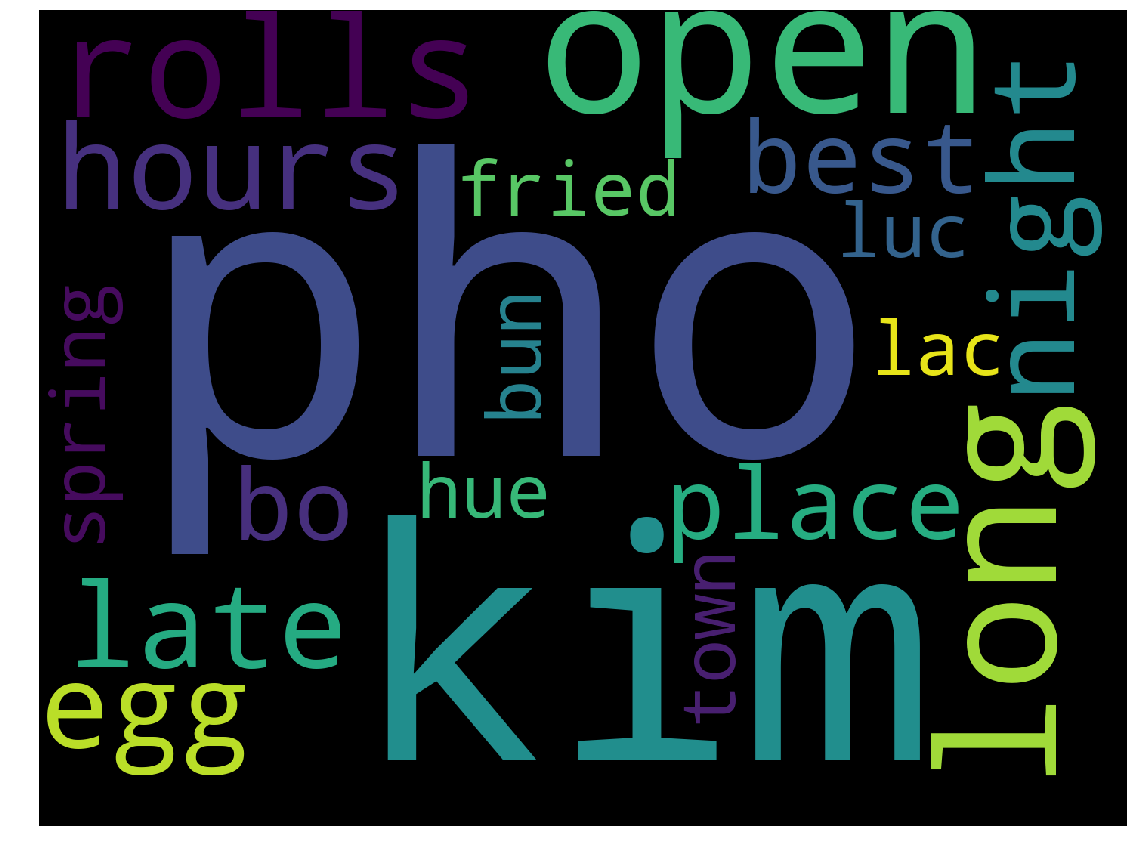


Analysing business:  SUSHISAMBA - Las Vegas
----- 10 most common 2-word phrase -----
sea bass: 84
sushi samba: 63
peruvian corn: 43
sushi rolls: 30
kobe beef: 26
las vegas: 25
el topo: 23
wagyu beef: 22
come back: 22
happy hour: 21

----- 10 most common 3-word phrase -----
sea bass skewers: 13
chilean sea bass: 12
el topo roll: 12
rock shrimp tempura: 11
salt pepper squid: 10
japanese brazilian peruvian: 10
seared wagyu beef: 7
crispy yellowtail taquitos: 7
tuna foie gras: 7
neo tokyo roll: 7



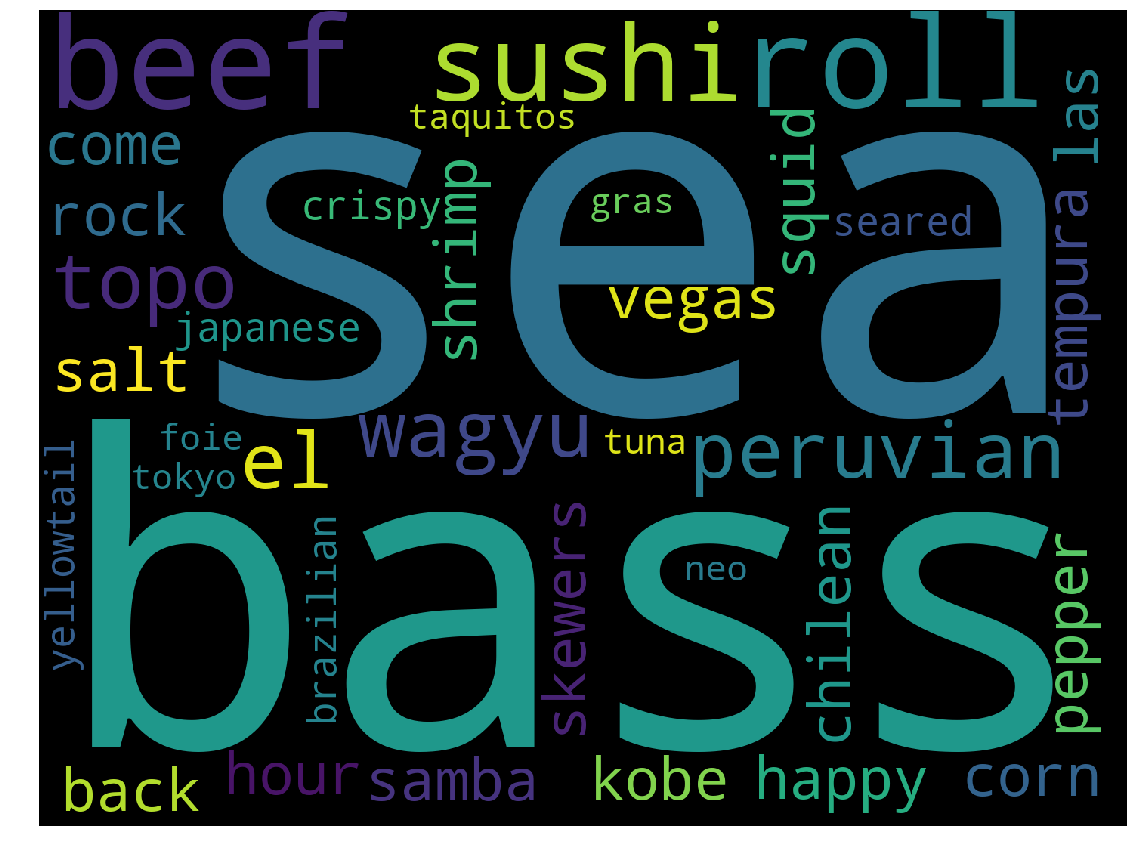


Analysing business:  Noodle Asia
----- 10 most common 2-word phrase -----
noodle soup: 91
beef noodle: 63
noodle asia: 52
fried rice: 44
chinese food: 42
bbq pork: 23
chinese restaurant: 15
las vegas: 14
hong kong: 13
asian food: 13

----- 10 most common 3-word phrase -----
beef noodle soup: 54
szechuan beef noodle: 9
pan fried noodles: 8
shrimp fried rice: 7
wonton noodle soup: 6
beef chow fun: 6
hot sour soup: 6
duck bbq pork: 5
bbq pork duck: 5
spicy beef noodle: 5



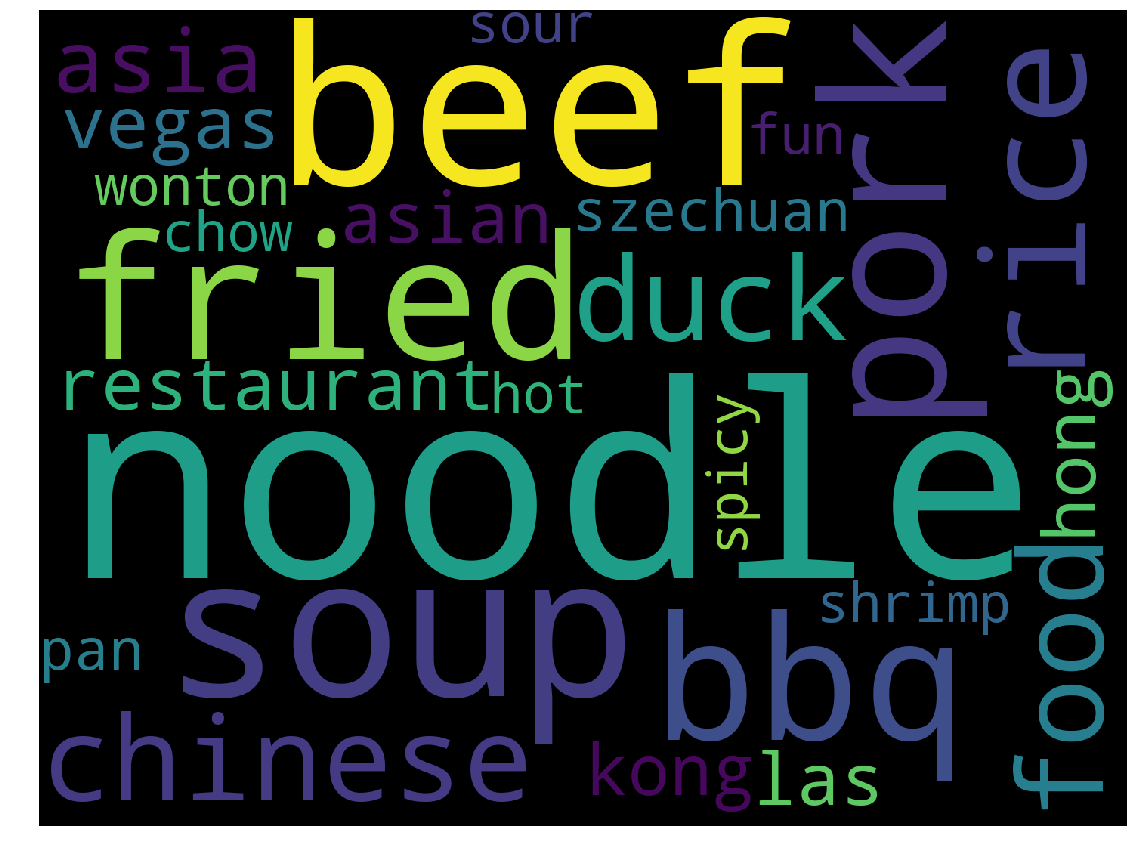

In [45]:
num_business_analysis = 3 # basically this will tell how much computing and diverse our analysis will be
business_ids=top_business_data.sort_values("rated")[::-1][:num_business_analysis].business_id.values
business_names = top_business_data.sort_values("rated")[::-1][:num_business_analysis]["Business name"].values
# get all the reviews and analyse them
#business_names
for i, business_id in enumerate(business_ids):
    # now extract reviews from reviews data
    print("Analysing business: ",business_names[i])
    reviews = chinese_reviews_df_norm.loc[(chinese_reviews_df_norm['business_id'] == business_id) & (chinese_reviews_df_norm['sentiment'] == 'positive')].text.values
    most_used_text = count_ngrams(reviews,max_length=3)
    print_most_frequent(most_used_text, num=10)
    print_word_cloud(most_used_text, 10)

## Observations

* Not surprisingly, most of the most frequent words or phrases are food. However, based on the sentiment, we can tell what customers like or dislike.
* Pho Kim Long, located Las Vegas, has both the most positive and negative reviews. The high volume of reviews can be attributed to the fact that the restaurant is open 24 hours a day, 7 days a week. This restaurant is frequented by tourists as we looked up their Yelp site: https://www.yelp.ca/biz/pho-kim-long-las-vegas